In [2]:
%load_ext autoreload
%autoreload 2

### Import required libraries

In [118]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

### Open the CSV files containing train and test data

In [4]:
train_df = pd.read_csv("./train_1.csv")
test_df = pd.read_csv("./test_1.csv")

### Reduce the size of dataframe to save memory during training

In [5]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 49.407928466796875  MB
**********
Column:  floor_area_sqm
dtype before:  float64
dtype after:  float32
**********
**********
Column:  lease_commence_date
dtype before:  int64
dtype after:  uint16
**********
**********
Column:  resale_price
dtype before:  float64
dtype after:  float32
**********
**********
Column:  month_no
dtype before:  int64
dtype after:  uint8
**********
**********
Column:  year
dtype before:  int64
dtype after:  uint16
**********
**********
Column:  storey
dtype before:  float64
dtype after:  uint8
**********
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  35.40904998779297  MB
This is  71.66673666876879 % of the initial size
Memory usage of properties dataframe is : 11.528717041015625  MB
**********
Column:  floor_area_sqm
dtype before:  float64
dtype after:  float32
**********
**********
Column:  lease_commence_date
dtype before:  int64
dtype after:  uint16
**********
**********
Column:  month_no
dtype before:  int64

### Training data

In [6]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,"(1.3690080642700195, 103.95869445800781)"
1,punggol,5-room,196B,punggol field,110.0,improved,2003,punggol field,punggol,north-east region,402300.0,10,2014,11,"(1.3990070819854736, 103.90699005126953)"
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,fernvale,sengkang,north-east region,351000.0,9,2020,2,"(1.3883482217788696, 103.87381744384766)"
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,clementi north,clementi,west region,151200.0,10,2000,8,"(1.3184930086135864, 103.7667007446289)"
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,bukit batok west,bukit batok,west region,318600.0,1,2013,8,"(1.3481495380401611, 103.74266052246094)"


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 431732 non-null  object 
 1   flat_type            431732 non-null  object 
 2   block                431732 non-null  object 
 3   street_name          431732 non-null  object 
 4   floor_area_sqm       431732 non-null  float32
 5   flat_model           431732 non-null  object 
 6   lease_commence_date  431732 non-null  uint16 
 7   subzone              431732 non-null  object 
 8   planning_area        431732 non-null  object 
 9   region               431732 non-null  object 
 10  resale_price         431732 non-null  float32
 11  month_no             431732 non-null  uint8  
 12  year                 431732 non-null  uint16 
 13  storey               431732 non-null  uint8  
 14  lat_long             431732 non-null  object 
dtypes: float32(2), ob

### Segregate the columns

In [8]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
]

### Drop the selected columns

In [9]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

<AxesSubplot:>

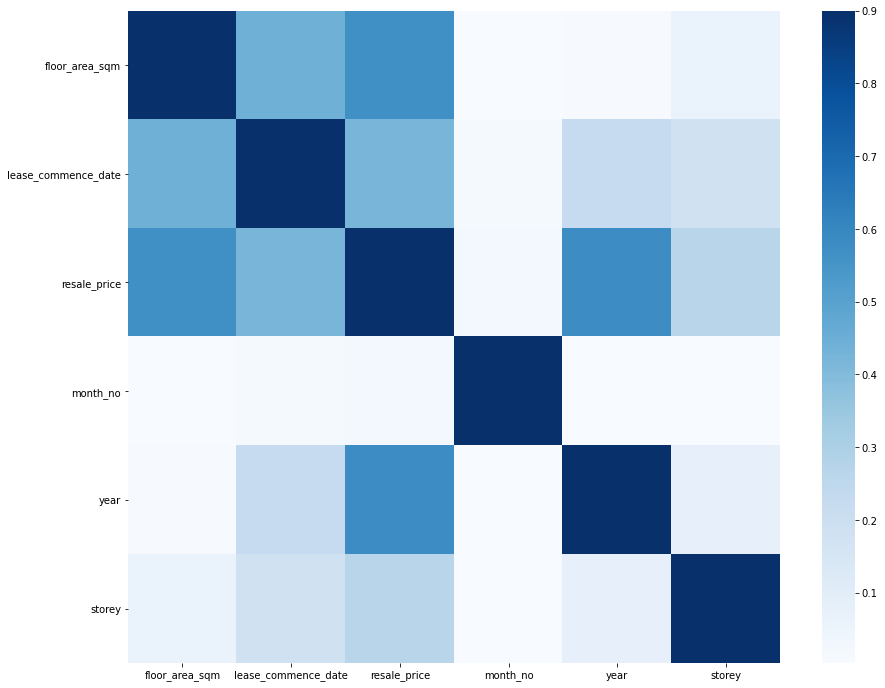

In [10]:
corr = train_df.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [11]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
month_no,0.025448


### One hot encode categorical columns

In [12]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [14]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [15]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Linear Regression

In [24]:
reg = LinearRegression(normalize=True,copy_X=True,n_jobs=-1)

In [25]:
%%time
reg.fit(train_x, train_y)

Wall time: 4.2 s


LinearRegression(n_jobs=-1, normalize=True)

In [101]:
train_prediction = reg.predict(train_x)
val_prediction = reg.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 53059.2
Validation error(RMSE) : 52960.05
R2 score for training data : 0.8327968020651763
R2 score for validation data : 0.8347324422388153


-----------------------

## Decision Tree

In [102]:
dt_1 = tree.DecisionTreeRegressor()

In [103]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 9.78 s


In [104]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 4135.424314825361
Validation error(RMSE) : 26053.668882305552
R2 score for training data : 0.9989843049682918
R2 score for validation data : 0.9600028924903291


In [75]:
dt_2 = tree.DecisionTreeRegressor(max_depth=30,min_samples_split=30)

In [76]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 8.57 s


In [105]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 18322.366594647665
Validation error(RMSE) : 23043.71425642023
R2 score for training data : 0.9800617833479406
R2 score for validation data : 0.9687107056211585


In [78]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [106]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14990.226031731854
Validation error(RMSE) : 23055.69087348334
R2 score for training data : 0.9866543559550573
R2 score for validation data : 0.968678172907427


In [122]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring=custom_kfold_scorer)
print("5 fold Cross validation scores(RMSE)",scores)

5 fold Cross validation scores(RMSE) [23796.00631699 23362.31911505 23517.73451212 23610.09484359
 23380.13437972]


In [125]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring='r2')
print("5 fold Cross validation scores(r2_score)",scores)

5 fold Cross validation scores(r2_score) [0.96634098 0.96781478 0.96699145 0.96705558 0.96743054]


----------------------------

## Random Forest

In [45]:
rf_1 = RandomForestRegressor()

In [46]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 10min 45s


RandomForestRegressor()

In [107]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 8032.754552656852
Validation error(RMSE) : 19760.948424964838
R2 score for training data : 0.996167764689788
R2 score for validation data : 0.976990542675913


#### Uncomment next block to make prediction on test data and generate csv

In [ ]:
#test_result = rf.predict(test_df)
#save_to_csv(test_result,"./random_forest_result.csv")

----------------------------

## XGBOOST

In [59]:
xgb_model_1 = xgboost.XGBRegressor()

In [60]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 60 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 21386.447
Validation error(RMSE) : 22213.234
R2 score for training data : 0.9728355840704717
R2 score for validation data : 0.9709253601086683


In [64]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [65]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 4min 27s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [109]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14211.767
Validation error(RMSE) : 21454.455
R2 score for training data : 0.9880044746015649
R2 score for validation data : 0.9728777483044407


#### Uncomment next block to make prediction on test data and generate csv

In [19]:
#test_result = best_xgb_model.predict(test_df)
#save_to_csv(test_result,"./xgboost_result.csv")

-------------------------------------

## Prediction using Random Forest and XGBOOST together

In [82]:
xgb_model_2_prediction = xgb_model_2.predict(train_x)
rf_1_prediction = rf_1.predict(train_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Training error :",mean_squared_error(train_y, final_pred, squared=False))
print("R2 score for training data :",r2_score(train_y,final_pred))

Training error : 9164.785682885738
R2 score for training data : 0.9950115249862006


In [83]:
xgb_model_2_prediction = xgb_model_2.predict(val_x)
rf_1_prediction = rf_1.predict(val_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Validation error :",mean_squared_error(val_y, final_pred, squared=False))
print("R2 score for validation data :",r2_score(val_y,final_pred))

Validation error : 19077.86795947138
R2 score for validation data : 0.9785537934723993


In [28]:
xgb_model_2_test_prediction = best_xgb_model.predict(test_df)
rf_1_test_prediction = rf_1.predict(test_df)
final_pred_t = 0.7*rf_1_test_prediction + 0.3*xgb_model_2_test_prediction
#save_to_csv(final_pred_t, "./xgb_rf_result.csv")

----------------------

## LightGBM

In [92]:
gbm_1 = lgb.LGBMRegressor()

In [93]:
gbm_1 = gbm_1.fit(train_x,train_y)

In [110]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 24680.622174521803
Validation error(RMSE) : 25135.611392082803
R2 score for training data : 0.9638227641200683
R2 score for validation data : 0.9627719993041836


In [97]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [98]:
gbm_2 = gbm_2.fit(train_x,train_y)

In [111]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13310.930431444354
Validation error(RMSE) : 17312.545992006693
R2 score for training data : 0.9894769895536533
R2 score for validation data : 0.9823391058776829


#### Uncomment next block to make prediction on test data and generate csv

In [ ]:
#gbm_test_result = gbm.predict(test_df)
#save_to_csv(gbm_test_result,"./lgbm_result.csv")

In [113]:
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=5000,n_estimators=5000)

In [114]:
gbm_3 = gbm_3.fit(train_x,train_y)

In [115]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14606.129528159705
Validation error(RMSE) : 17310.28080354462
R2 score for training data : 0.987329508274829
R2 score for validation data : 0.9823437271086044


## Prediction using Random Forest, XGBOOST and LightGBM together

In [97]:
print("Training error :",mean_squared_error(train_y, , squared=False))
print("Validation error :",mean_squared_error(val_y, 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x), squared=False))

Training error : 11809.782908391793
Validation error : 13263.875122234342


In [116]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 10510.399167378899
Validation error(RMSE) : 17774.406924960822
R2 score for training data : 0.9934391275532936
R2 score for validation data : 0.9813842283136099


#### Uncomment next block to make prediction on test data and generate csv

In [117]:
#test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./lgbm_xgboost_rf_result.csv")